In [43]:
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd
#from geodatasets import get_path
import geodatasets
import osmnx as ox 
import shapely
#import rasterio
from shapely.geometry import Point, Polygon 
from shapely.geometry import LineString
from matplotlib.animation import FuncAnimation
import math 

In [3]:
place_name = 'Austin, Texas, USA'

austin_gdf = ox.geocode_to_gdf(place_name) #converts named geocode - 'Austin,Texas' location to gdf 
austin_utm_gdf = ox.projection.project_gdf(austin_gdf) #default projection - UTM projection 
austin_utm_gdf['boundary'] = austin_utm_gdf.boundary #adding column 'boundary' 

austin_hospital = ox.features.features_from_polygon(austin_gdf['geometry'][0], tags={'building':'hospital'})
austin_utm_hospital = ox.projection.project_gdf(austin_hospital)
austin_utm_hospital_buffer = austin_utm_hospital.buffer(500)



### Need to restructure this part - 

GeoPandas uses Shapely primitives, GeoPandas also comes with its own datastructure.
Need to restructure and use GeoPanda primitives for mapping collision avoidance

In [5]:
#* Spawning inside the boundary of Austin - generalize this 
sample_points_gdf = austin_utm_gdf.sample_points(2) # returns two random points in the map 
print(type(sample_points_gdf), ' -- ', len(sample_points_gdf))
#* Define start and end explicitly
sample_points = sample_points_gdf[0]
print(type(sample_points))

<class 'geopandas.geoseries.GeoSeries'>  --  1
<class 'shapely.geometry.multipoint.MultiPoint'>


In [7]:
coords = []
for point in sample_points.geoms:
    x = point.x
    y = point.y
    coords.append((x,y))
connecting_line = LineString(coords) #this line is built using 2 sampled points

#* Creating an array of points for the plane to follow 
num_points = 21 

# interpolated_points[Tuple(x,y)]
interpolated_points = []

interpolated_shapely_points = [connecting_line.interpolate(i/num_points, normalized=True) for i in range(1,num_points)]
for i in range(len(interpolated_shapely_points)):
    temp_container = shapely.get_coordinates(interpolated_shapely_points[i])
    x,y = temp_container[0]
    interpolated_points.append((x,y))

<Axes: >

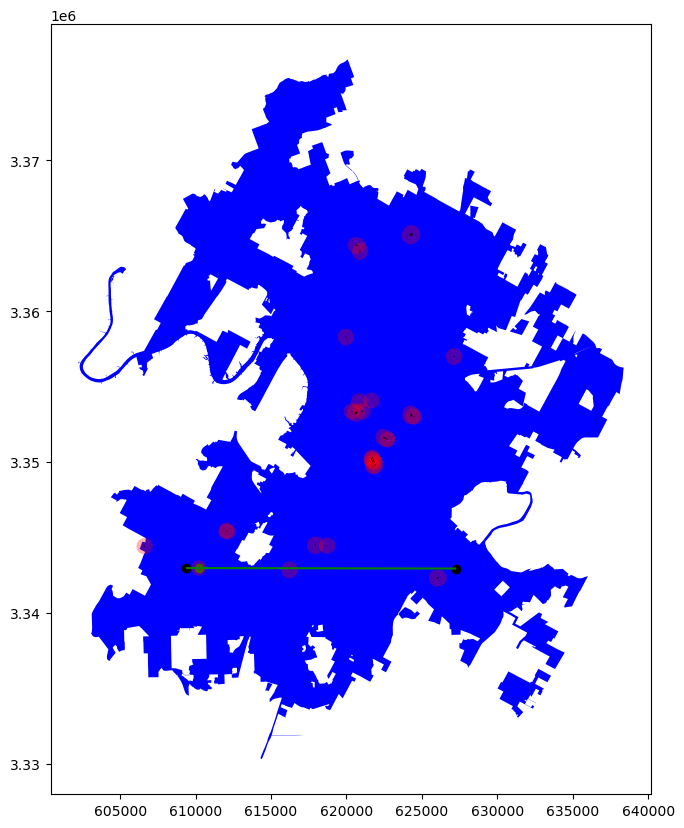

In [9]:
#* Existing code for the initial plot setup
fig, ax = plt.subplots(figsize=(20, 10))
austin_utm_gdf.plot(ax=ax, color='blue', linewidth=0.6)
austin_utm_hospital_buffer.plot(ax=ax, color='red', alpha=0.3)
austin_utm_hospital.plot(ax=ax, color='black')
sample_points_gdf.plot(ax=ax, color='black')
gpd.GeoSeries([connecting_line]).plot(ax=ax, color='green')

#adding the drone
drone_point = ax.scatter(interpolated_points[0][0], interpolated_points[0][1],color='g')
drone_gs_point = gpd.GeoSeries(Point(interpolated_points[0][0], interpolated_points[0][1]))
drone_buffer = drone_gs_point.buffer(500)
drone_buffer.plot(ax=ax, color='red', alpha=0.3)







## TESTING SHAPELY MODULE 

In [5]:
from shapely import Point, LinearRing, LineString, Polygon

rectangle = Polygon(((0,0),(1,1),(2,2)))
rectangle.is_valid

coords = ((0,0),(1,1),(1,0),)
poly = Polygon(coords)
poly.is_valid

True

In [6]:
line_ring_coords = ((1,0),(1,1), (0,0))
line_ring = LinearRing(line_ring_coords)

#First use of filter and lambda during project 
attrib_line_ring = filter(lambda x: not x.startswith('_'), dir(line_ring))
#list(attrib_line_ring)

class Something:
    def __init__(self, prop_a, prop_b):
        self.prop_a = prop_a
        self.prop_b = prop_b
    
    def do_something(self,):
        print('doing something')

some = Something(1,'b')
getattr(some, 'prop_a')
delattr(some, 'prop_b')

x = [1,2,3]
y = [4,5,6]

a = zip(*zip(x,y))
print(list(a))

dict_a = {1:'a', 2:'b'}




[(1, 2, 3), (4, 5, 6)]


In [7]:
coords_a = (0,0)
point_a = Point(coords_a).buffer(10,1)
print(len(point_a.exterior.coords))
print(list(point_a.exterior.coords))
print(point_a.convex_hull)


5
[(10.0, 0.0), (6.123233995736766e-16, -10.0), (-10.0, -1.2246467991473533e-15), (-1.8369701987210296e-15, 10.0), (10.0, 0.0)]
POLYGON ((0.0000000000000006 -10, -10 -0.0000000000000012, -0.0000000000000018 10, 10 0, 0.0000000000000006 -10))


In [ ]:
## Testing drawing the buffer zone over a geoseries-point 

fig, ax = plt.subplots()
drone_coord = (1,2)
drone = Point(drone_coord)
drone_gs = gpd.GeoSeries(drone)




### END TEST SHAPELY 

### Testing GeoPandas Library

matplotlib.lines.Line2D

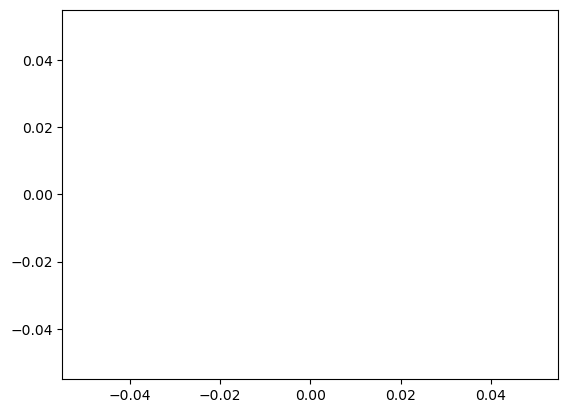

In [38]:
fig,ax = plt.subplots()
line = ax.plot([],[])



### End testing GeoPandas 

In [7]:
#* Animation update function
def update(frame):
    airplane.set_offsets((interpolated_points[frame][0], interpolated_points[frame][1]))
    
    # point = interpolated_points[frame]
    # ax.plot(point.x, point.y, 'x')  # Plotting each point as an 'x'
    # return ax,
    return airplane

#* Create animation
ani = FuncAnimation(fig, update, frames=len(interpolated_points), interval=200, repeat=False)
#                  what is the value of len(interpolated_points)

plt.show()

In [3]:
import math
startpoint = (1200,1200)
endpoint = (2400,2400)

speed = 80 # Airbus H175 - max curise speed 287 kmph - 79 meters per second
heading_radians = math.pi/4 # heading is in radians

del_time = 0.5

def update_position(current_position, speed=80, heading=math.pi/4):
    current_x = current_position[0]
    current_y = current_position[1]
    update_x = current_x + del_time*speed*math.cos(heading)
    update_y = current_y + del_time*speed*math.sin(heading)
    current_position = (update_x,update_y)
    return current_position

def speed_controller(current_position, destination):
    while current_position <= destination:
        current_position = update_position(current_position)
    print('Reached destination:', current_position)



# time = 1
# current_position = startpoint
# while time < 20 :
#     current_position = speed_controller(current_position, endpoint)
#     print(f'This is the current position of the aircraft, x ->{current_position[0]} -- y ->{current_position[1]} ')
#     time += 1 
speed_controller(current_position=startpoint, destination=endpoint)

Reached destination: (2416.2236636408643, 2416.223663640859)


#### need to define update def of theta 
    #start with random heading
    #slowly change towards final destination 
        #create a reference final heading using start and endpoint 
        #create a random heading for aircraft 
        #at every del_t update current heading towards reference final heading 
#### need to create a dynamic function for de-accelerating when we get close to destination 

##### Testing python sinusoidal 

In [9]:
theta_rad = -1*np.pi / 2
theta_deg = theta_rad * (180/np.pi)

Angle = namedtuple('Angle', 'theta, degree')

np.arctan2(-1,-1) * (180/np.pi)



NameError: name 'namedtuple' is not defined

In [ ]:
#lets create some random thetas 
theta_list = np.linspace(-np.pi,np.pi)
#one choice of theta
theta_rad = np.random.choice(theta_list)
theta_deg = theta_rad * (180/np.pi)
theta_deg


-47.75510204081634

In [ ]:

#! destination_heading_calculator() is update_ref_final_heading()

def destination_heading_calculator(current_position, destination):
    '''Returns the heading of the aircraft, pointed towards destination'''
    destination_heading = np.arctan2(destination.y - current_position.y, destination.x - current_position.x)
    return destination_heading

In [ ]:
ref_final_heading_rads = np.arctan2(endpoint[1] - startpoint[1], endpoint[0] - startpoint[0]) # radian endpoint(x,y) startpoint(x,y)

ref_final_heading_deg = np.rad2deg(ref_final_heading_rads)
start_heading_deg = np.random.randint(-179,179) # this is noise -> + random.random() # this is in degrees
 #this is in degrees


# todo this function will take current heading, and heading calculated using destination_heading_calculator, the ref_final_heading needs to use this method

def heading_correction(current_heading, ref_final_heading_deg = ref_final_heading_deg): # radian
    avg_rate_of_turn = 20

    #! need to find if the start heading is to the left or right of ref_final_heading
    #! need to find how to dynamically slow down the turn rate as we get close to the ref_final_heading
    
    if np.abs(ref_final_heading_deg - current_heading) < avg_rate_of_turn:
        avg_rate_of_turn = 1 #radian
    
    #* logic for heading update 
    if (np.sign(ref_final_heading_deg)==np.sign(current_heading)==1):
        # and (ref_final_heading > current_heading)) or ((np.sign(ref_final_heading)==np.sign(current_heading)== -1) and (np.abs(ref_final_heading)<(np.abs(current_heading)))):
        if ref_final_heading_deg > current_heading:
            current_heading += avg_rate_of_turn #counter clockwise turn 
        elif ref_final_heading_deg < current_heading:
            current_heading -= avg_rate_of_turn #clockwise turn
        else:
            pass  
    
    elif np.sign(ref_final_heading_deg) == np.sign(current_heading) == -1:
        if np.abs(ref_final_heading_deg) < np.abs(current_heading):
            current_heading += avg_rate_of_turn #counter clockwise turn
        elif np.abs(ref_final_heading_deg) > np.abs(current_heading):
            current_heading -= avg_rate_of_turn #clockwise turn
        else:
            pass
            
    elif np.sign(ref_final_heading_deg) == 1 and np.sign(current_heading) == -1:
        current_heading += avg_rate_of_turn #counter clockwise turn

    elif np.sign(ref_final_heading_deg) == -1 and np.sign(current_heading) == 1:
        current_heading -= avg_rate_of_turn #clockwise turn

    else:
        raise Exception
    
    return current_heading
    
        

current_heading = start_heading_deg

print(f'System start : Final ref heading -> {ref_final_heading_deg}, current heading -> {current_heading}')


# todo - here the final heading is static, in 

while np.abs(current_heading - ref_final_heading_deg) > 0.1:
    current_heading = heading_correction(current_heading)
    print(f'final ref heading -> {np.rad2deg(ref_final_heading_rads)}, current heading -> {current_heading}')
    


System start : Final ref heading -> 45.0, current heading -> -81
final ref heading -> 45.0, current heading -> -61
final ref heading -> 45.0, current heading -> -41
final ref heading -> 45.0, current heading -> -21
final ref heading -> 45.0, current heading -> -1
final ref heading -> 45.0, current heading -> 19
final ref heading -> 45.0, current heading -> 39
final ref heading -> 45.0, current heading -> 40
final ref heading -> 45.0, current heading -> 41
final ref heading -> 45.0, current heading -> 42
final ref heading -> 45.0, current heading -> 43
final ref heading -> 45.0, current heading -> 44
final ref heading -> 45.0, current heading -> 45


#### testing update_heading method

#### How is movement accomplished 

1) update position with initial heading ** in next step of loop initial heading becomes updated heading 
2) update heading 


In [ ]:
def step():
    update_position()
    heading_correction()
    return current_position, current_heading


#### Test the following 

1) Test buffer zone movement with a specific point - need to have two buffer zone, NMAC and collision 
2) Test NMAC and collision detection during overlap

### Testing matplotlib 

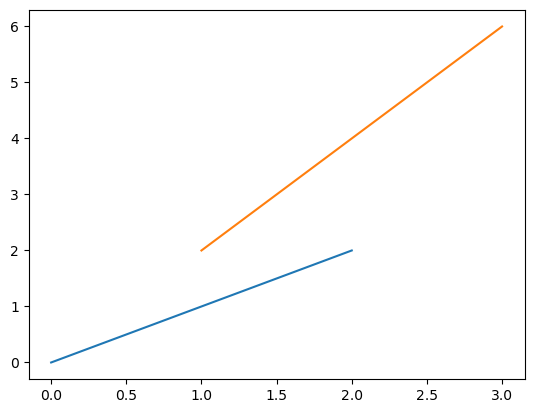

In [53]:
fig, ax = plt.subplots()

line = ax.plot([0,1,2],[0,1,2])
line2 = ax.plot([1,2,3],[2,4,6])



### End matplotlib